In [17]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [18]:
paises = ["Italy", "France", "Germany", "England", "Spain"]
year_of_interest_int = 2018
year_of_interest_str = "2018"

#Funcion para calcular inflacion acumulada
def inf_acum(año):
    inflacion = [1.74118084746924, 1.87084961406325, 2.84327019799065, 3.18466272791609, 3.86856354936628,3.90803782779623,
             3.87365401861331, 3.45533218314714, 2.76486447339765, 2.65725273386971, 4.37282441582136,5.24097448273095,
             6.06300309718188, 8.02220995878935, 13.6493174728139, 12.7681985920515, 9.79734643716299,10.6439507951549,
             7.75523144587006, 9.05684784238687, 12.5785990487562, 13.3144055680071, 11.9784719523806,9.45954847235317,
             7.67380262247321, 5.39548620170352, 2.93357920442327, 3.28889821400134, 2.70081527508112,4.08905388153545,
             3.44831217961808, 4.04703259753466, 5.16378397662331, 4.5218241221731, 3.50262577413398,3.37384030440144,
             2.57299919930232, 2.00709087666531, 1.95711094996816, 1.66345995007715, 2.85303039287157,2.72449326646328,
             2.63323912175956, 2.38551385959886, 2.21620788926273, 2.47212179047864, 2.7200475052927,2.48231546689541,
             4.11407022033816, 0.437175412792704, 1.5205755786839, 3.28801427219793, 2.54154474108013,1.31023355618665,
             0.220195628198783, -0.085207229696361, 0.166009884375597, 1.37503641525343, 1.68923965804135,1.44123966942342, 0.186938139702113, 2.48650438120822, 8.4711764559089, 5.78431554960867,2.18497406958038]
    year = [i for i in range(1960, 2025)]
    indice = year.index(año)
    inflacion = inflacion[indice:]
    acum = 1
    for i in inflacion:
        i = i / 100
        acum = acum * (1 + i)
    acum_f = acum
    return (acum_f - 1)

#Archivos a usar
df_comp = pd.read_csv('competitions.csv')
df_clubes = pd.read_csv('clubs.csv')
df_jugadores = pd.read_csv("players.csv")
df_stats = pd.read_csv("game_lineups.csv")
df_eventos = pd.read_csv('game_events.csv')

#Obtengo id de competencias de las 5 mejores ligas para poder saber que clubes compiten allí
df_comp_it = df_comp[(df_comp["country_name"].isin(paises)) & (df_comp["type"] == "domestic_league")]
id_comp = df_comp_it["competition_id"].tolist()

#CLUBES DE PRIMERA de los ultimos años de las ligas seleccionadas
df_clubes_1 = df_clubes[(df_clubes["domestic_competition_id"].isin(id_comp)) & (df_clubes["last_season"] >= year_of_interest_int)]
lista_club_1 = df_clubes_1["name"].tolist()

#VALOR real de los jugadores, será la variable objetivo del proyecto
df_jugadores['inf_acum'] = df_jugadores.apply(lambda fila: inf_acum(fila['last_season']), axis=1)
df_jugadores["valor_real"] = (df_jugadores["inf_acum"] + 1) * df_jugadores["market_value_in_eur"]

#ME QUEDO CON LOS JUGADORES QUE HAN JUGADO DESDE 2020 HASTA 2024 EN ALGUN EQUIPO DE PRIMERA DE LAS LIGAS SELECCIONADAS
df_jugadores_it = df_jugadores[(df_jugadores["current_club_name"].isin(lista_club_1)) & (df_jugadores["last_season"] >= year_of_interest_int)].copy()

#CALCULO la edad de cada jugador
df_jugadores_it["date_of_birth"] = pd.to_datetime(df_jugadores_it["date_of_birth"])
df_jugadores_it["last_season"] = pd.to_numeric(df_jugadores_it["last_season"], errors="coerce")
df_jugadores_it["edad"] = (( pd.to_datetime(df_jugadores_it["last_season"], format="%Y")) - df_jugadores_it["date_of_birth"]).dt.days // 365

#Apariciones en la planilla de cada jugador
lista_id_jug = df_jugadores_it["player_id"].tolist()
df_stats_jug = df_stats[(df_stats["player_id"].isin(lista_id_jug)) & (df_stats["date"] >= year_of_interest_str)]

apariciones = df_stats_jug["player_id"].value_counts().rename("apariciones")
titular = (df_stats_jug[df_stats_jug["type"] == "starting_lineup"]["player_id"].value_counts()).rename("titular")
capitan = df_stats_jug[df_stats_jug["team_captain"] == 1]["player_id"].value_counts().rename("capitanias")

#Eventos del partido(Goles y Asistencias)
#FECHA

df_eventos = df_eventos[(df_eventos["date"] >= year_of_interest_str) & (df_eventos["date"] < "2025") & (df_eventos["type"] == "Goals")]
#Goles y Asistencias

pos_ofensivas = ["Attacking Midfield", "Second Striker", "Centre-Forward", "Right Winger", "Left Winger"]
goles = df_eventos[df_eventos["type"] == "Goals"].value_counts("player_id").rename("goles")
asistencias = df_eventos["player_assist_id"].value_counts().rename("asistencias")

# merge final
df_final = df_jugadores_it.merge(apariciones, on="player_id", how="left").merge(titular, on="player_id",how="left").merge(capitan,on="player_id",how="left").merge(goles, on="player_id", how="left").merge(asistencias, left_on="player_id",right_on="player_assist_id", how="left")

#Otros atributos

df_final["jugador_ofensivo"] = df_final["sub_position"].isin(pos_ofensivas).astype(int)
df_final["efectividad"] = (df_final["goles"] + df_final["asistencias"]) / df_final["apariciones"]

	Gráfico 1:Distribución del valor real de los jugadores


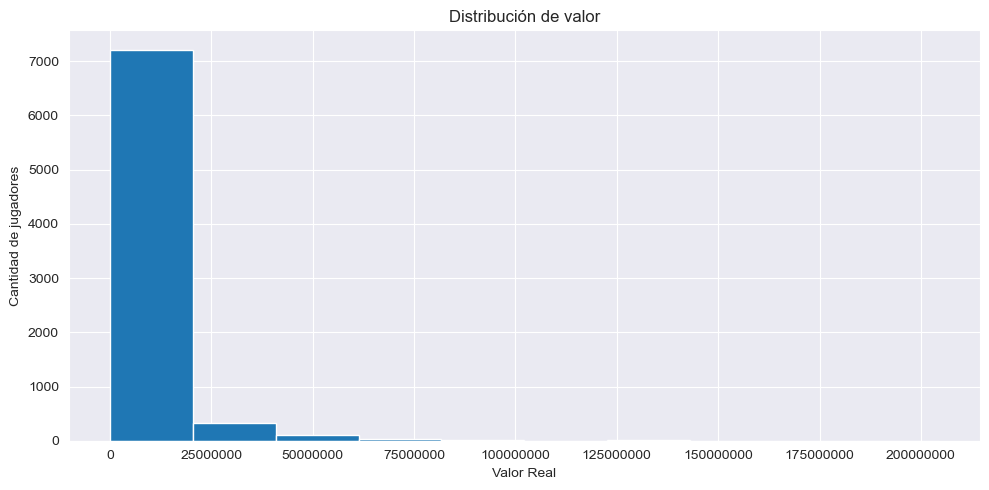

	Gráfico 2:Distribución de las posiciones de los jugadores


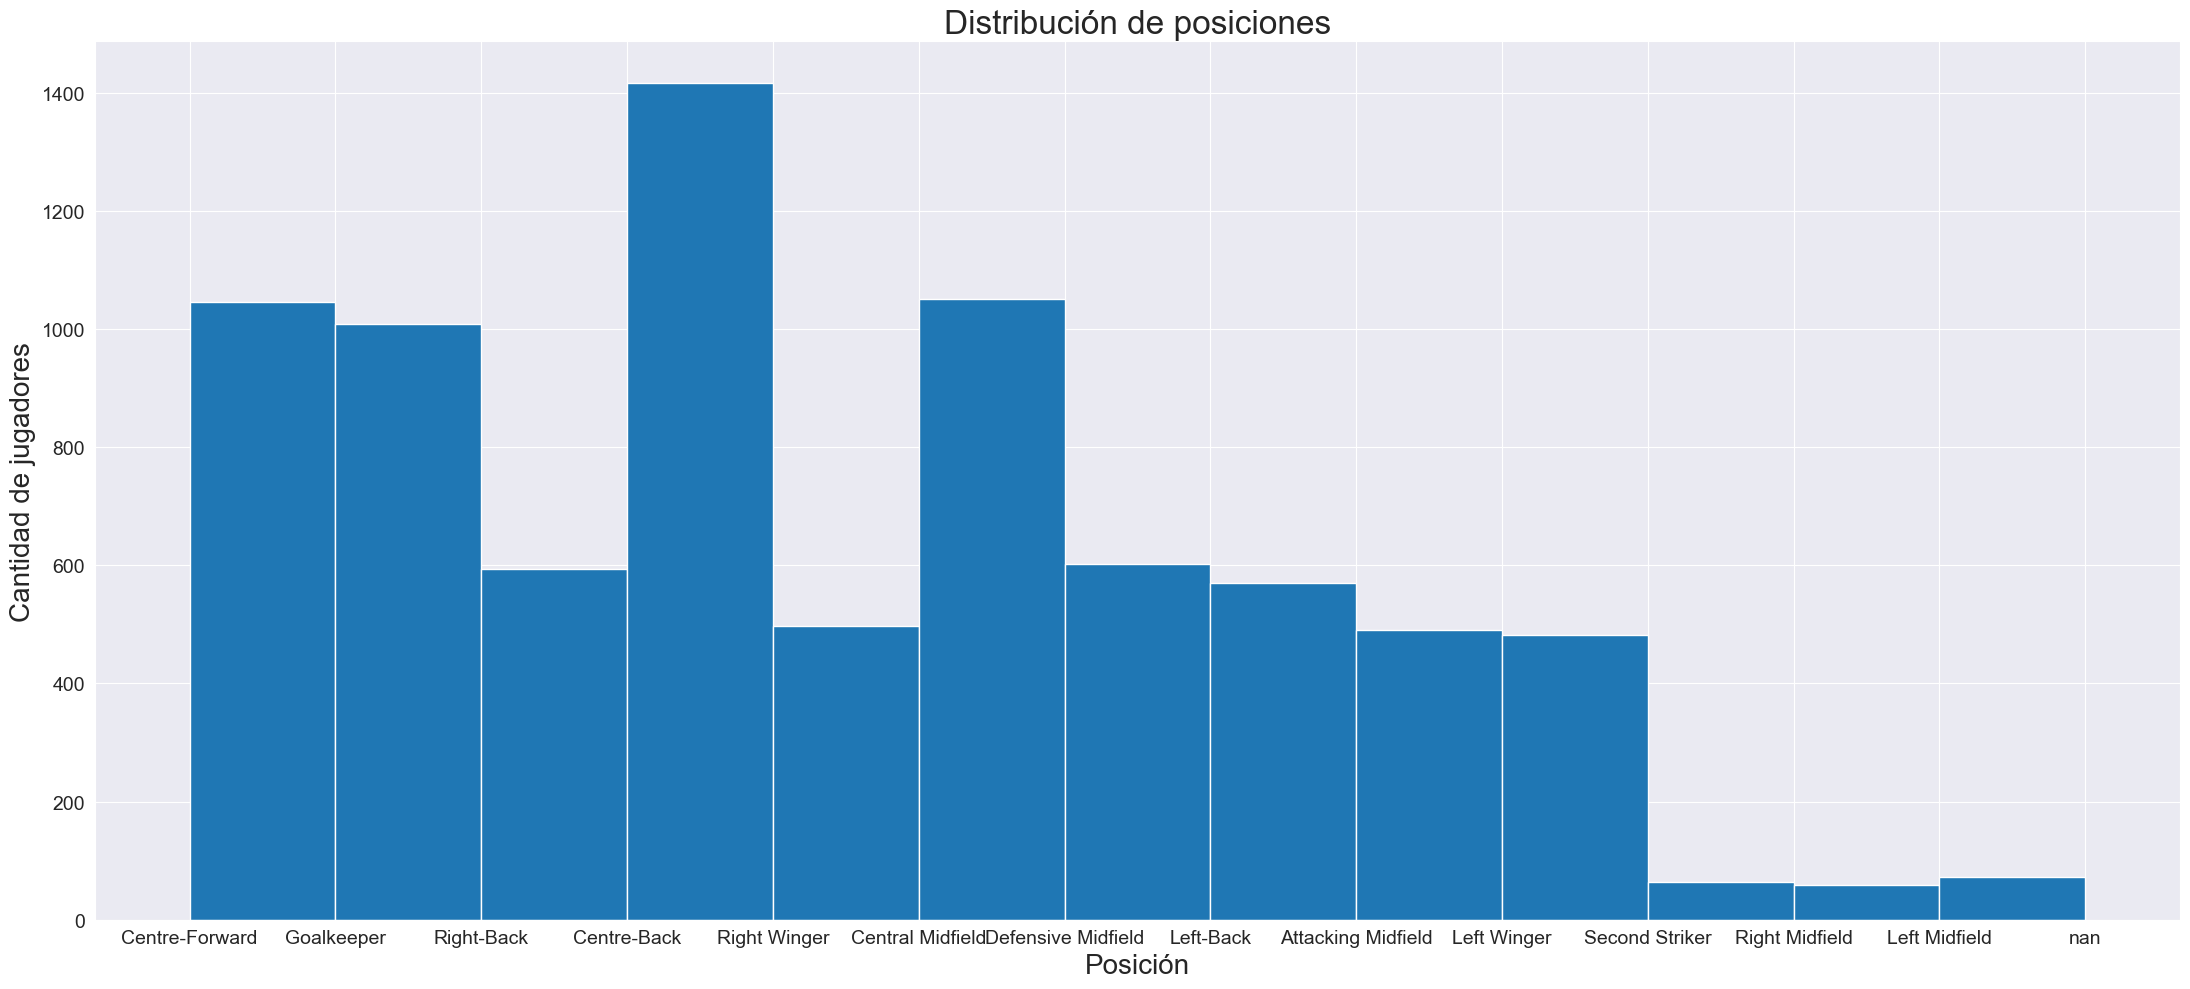

	Gráfico 3:matriz de correlaciones de variables numéricas.


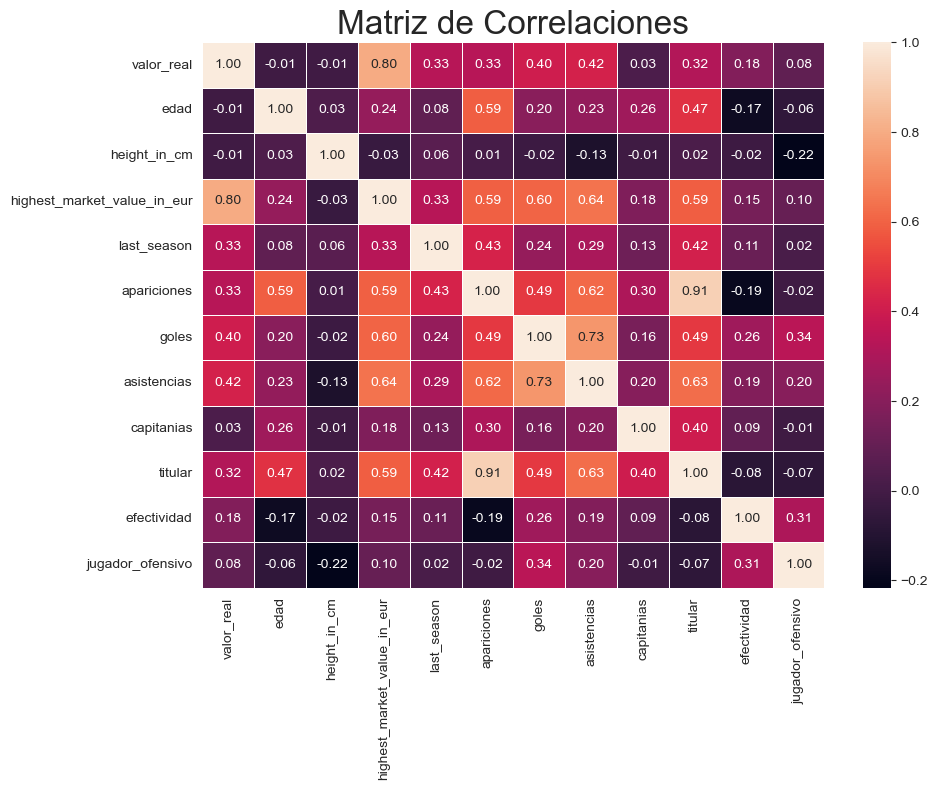

In [23]:
#Graficos

print('\tGráfico 1:Distribución del valor real de los jugadores')
plt.figure(figsize=(10, 5))
plt.hist(df_jugadores_it["valor_real"])
plt.ticklabel_format(style='plain', axis='x')
plt.title("Distribución de valor")
plt.xlabel("Valor Real")
plt.ylabel("Cantidad de jugadores")
plt.tight_layout()
plt.show()

print(f'\tGráfico 2:Distribución de las posiciones de los jugadores')
plt.figure(figsize=(22, 10))
plt.hist(df_jugadores_it["sub_position"].astype(str), bins=13)
plt.title("Distribución de posiciones", fontsize=24)
plt.xlabel("Posición", fontsize=20)
plt.ylabel("Cantidad de jugadores", fontsize=20)
plt.xticks(fontsize=14)#cambian el tamaño de valores sobre el eje de x e y
plt.yticks(fontsize=14)
plt.tight_layout()#para que no se superpongan
plt.show()

print(f'\tGráfico 3:matriz de correlaciones de variables numéricas.')
corr = df_final[["valor_real", "edad", "height_in_cm", "highest_market_value_in_eur", "last_season", "apariciones", "goles","asistencias", "capitanias", "titular", "efectividad", "jugador_ofensivo"]].corr()
f, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(corr, annot=True, linewidths=.5, fmt=".2f")
plt.title("Matriz de Correlaciones", fontsize=24)
plt.tight_layout()
plt.show()

#OUTLIERS
q1 = df_jugadores_it["valor_real"].quantile(0.25)
q3 = df_jugadores_it["valor_real"].quantile(0.75)
iqr = q3 - q1
lim_sup = q3 + 3 * iqr
lim_inf = q1 - 3 * iqr
#df_final=df_final[(df_final["valor_real"]<=lim_sup)&(df_final["valor_real"]>=lim_inf)]
#No quito outliers porque empeora el MAE de los modelo

In [20]:
#ELIMINO faltantes y columnas que no voy a usar
df_final = df_final.dropna(subset=["height_in_cm","valor_real"])
df_final = df_final.drop(["current_club_name", "current_club_domestic_competition_id", "player_code", "image_url", "city_of_birth", "url","first_name","contract_expiration_date","date_of_birth","inf_acum","last_name","name","player_id","position","market_value_in_eur"], axis=1)

#CORRECCIONES finales
df_final["current_club_id"]=df_final["current_club_id"].astype(str)


In [24]:
df_final

,last_season,current_club_id,country_of_birth,country_of_citizenship,sub_position,foot,height_in_cm,agent_name,highest_market_value_in_eur,valor_real,edad,apariciones,titular,capitanias,goles,asistencias,jugador_ofensivo,efectividad
0,2019,86,Peru,Peru,Centre-Forward,right,184.0,NaN,12000000.0,488511.727045,40.0,80.0,8.0,NaN,10.0,3.0,1,0.1625
1,2019,127,Germany,Germany,Goalkeeper,right,188.0,NaN,1000000.0,61063.965881,36.0,11.0,5.0,NaN,NaN,NaN,0,NaN
3,2019,162,Switzerland,Switzerland,Goalkeeper,right,194.0,KBM,11500000.0,305319.829403,35.0,53.0,28.0,1.0,NaN,NaN,0,NaN
5,2018,4,Germany,Germany,Goalkeeper,right,184.0,NaN,1250000.0,62095.482609,34.0,9.0,1.0,NaN,NaN,NaN,0,NaN
6,2019,38,Germany,Germany,Goalkeeper,right,190.0,Sports360 GmbH,4500000.0,366383.795284,34.0,48.0,33.0,1.0,NaN,1.0,0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7935,2024,3911,NaN,Mali,Defensive Midfield,right,164.0,BLACKSKILL,200000.0,204369.948139,17.0,NaN,NaN,NaN,NaN,NaN,0,NaN
7942,2024,417,NaN,Nigeria,Centre-Forward,right,194.0,Maître Ted DIMVULA,500000.0,510924.870348,17.0,NaN,NaN,NaN,NaN,NaN,1,NaN
7945,2023,3524,Cote d'Ivoire,Cote d'Ivoire,Centre-Back,right,174.0,BLACKSKILL,50000.0,54047.837707,17.0,NaN,NaN,NaN,NaN,NaN,0,NaN
7947,2024,35,NaN,The Gambia,Centre-Forward,NaN,185.0,David Moss Group,500000.0,510924.870348,20.0,NaN,NaN,NaN,3.0,2.0,1,NaN


In [22]:
df_final.to_csv("df_final2.csv",index=False)